# Power Market Price Time Series

## Import (Library and Data) 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR

In [2]:
# # Load the dataset
# df = pd.read_csv("")
# # df = pd.DataFrame(df)

# df.info()
# df.describe()

# df.shape
# df.columns
# df.index
# df.dtypes

# df.head()
# df.tail()

## Data Conversion and Cleaning

In [3]:
# ## time stamp
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df.set_index('timestamp', inplace=True) # index

# # Resample hourly to daily for smoother trends (if required)
# df_daily = df['price'].resample('D').mean()

In [4]:
# ## missing data
# df.isnull().sum()

# df['price'].fillna(df['price'].mean(), inplace=True)
# df['price'].fillna(method='ffill', inplace=True)

In [5]:
# ## duplicate
# df.drop_duplicates(inplace=True)

# CAISO Analysis

## Data Preparation

### CAISO LMP 

In [6]:
import gridstatus
import plotly.express as px

# iso = gridstatus.CAISO()
# df = iso.get_as_prices(date="Oct 15, 2022")
# df

In [7]:
caiso = gridstatus.CAISO()

start = pd.Timestamp("April 1, 2025").normalize()
end = pd.Timestamp.now().normalize()

locations = ["TH_NP15_GEN-APND", "TH_SP15_GEN-APND", "TH_ZP26_GEN-APND"]

lmp_df = caiso.get_lmp(
    start=start, end=end, market="DAY_AHEAD_HOURLY", locations=locations, sleep=5
)
lmp_df.head()


  0%|          | 0/2 [00:00<?, ?it/s]2025-05-05 15:29:19 - DEBUG - Dataset config: {'query': {'path': 'SingleZip', 'resultformat': 6, 'queryname': 'PRC_LMP', 'version': 12}, 'params': {'market_run_id': 'DAM', 'node': None, 'grp_type': [None, 'ALL', 'ALL_APNODES']}}
2025-05-05 15:29:19 - INFO - Fetching URL: http://oasis.caiso.com/oasisapi/SingleZip?resultformat=6&queryname=PRC_LMP&version=12&market_run_id=DAM&node=TH_NP15_GEN-APND,TH_SP15_GEN-APND,TH_ZP26_GEN-APND&startdatetime=20250401T07:00-0000&enddatetime=20250502T07:00-0000
2025-05-05 15:29:24 - DEBUG - Found 1 files: ['20250401_20250502_PRC_LMP_DAM_20250505_12_29_20_v12.csv']
2025-05-05 15:29:24 - DEBUG - Parsing file: 20250401_20250502_PRC_LMP_DAM_20250505_12_29_20_v12.csv
 50%|█████     | 1/2 [00:10<00:10, 10.24s/it]2025-05-05 15:29:29 - DEBUG - Dataset config: {'query': {'path': 'SingleZip', 'resultformat': 6, 'queryname': 'PRC_LMP', 'version': 12}, 'params': {'market_run_id': 'DAM', 'node': None, 'grp_type': [None, 'ALL', 'AL

,Time,Interval Start,Interval End,Market,Location,Location Type,LMP,Energy,Congestion,Loss
0,2025-04-01 00:00:00-07:00,2025-04-01 00:00:00-07:00,2025-04-01 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,24.87411,25.44473,-0.00829,-0.56233
1,2025-04-01 00:00:00-07:00,2025-04-01 00:00:00-07:00,2025-04-01 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,24.12878,25.44473,-0.24727,-1.06868
2,2025-04-01 00:00:00-07:00,2025-04-01 00:00:00-07:00,2025-04-01 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_ZP26_GEN-APND,Trading Hub,24.45747,25.44473,0.00000,-0.98726
3,2025-04-01 01:00:00-07:00,2025-04-01 01:00:00-07:00,2025-04-01 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,24.21639,24.89866,-0.02743,-0.65483
4,2025-04-01 01:00:00-07:00,2025-04-01 01:00:00-07:00,2025-04-01 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,23.82513,24.89866,-0.14232,-0.93121


In [8]:
negative_lmps = lmp_df[lmp_df["LMP"] < 0].set_index("Time")
negative_per_day = (
    negative_lmps.groupby("Location").resample("D")["LMP"].count().reset_index()
)

fig = px.bar(
    negative_per_day,
    x="Time",
    y="LMP",
    title="Negative LMPs per Month - CAISO",
    color="Location",
)

fig.update_yaxes(title="Number of Negative LMPs")
fig.show()

In [9]:
lmp_df['Time'] = pd.to_datetime(lmp_df['Time'], format='%Y-%m-%d %H:%M:%S')
lmp_df.set_index('Time', inplace=True)
lmp_df.head()

,Interval Start,Interval End,Market,Location,Location Type,LMP,Energy,Congestion,Loss
Time,,,,,,,,,
2025-04-01 00:00:00-07:00,2025-04-01 00:00:00-07:00,2025-04-01 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,24.87411,25.44473,-0.00829,-0.56233
2025-04-01 00:00:00-07:00,2025-04-01 00:00:00-07:00,2025-04-01 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,24.12878,25.44473,-0.24727,-1.06868
2025-04-01 00:00:00-07:00,2025-04-01 00:00:00-07:00,2025-04-01 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_ZP26_GEN-APND,Trading Hub,24.45747,25.44473,0.00000,-0.98726
2025-04-01 01:00:00-07:00,2025-04-01 01:00:00-07:00,2025-04-01 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,24.21639,24.89866,-0.02743,-0.65483
2025-04-01 01:00:00-07:00,2025-04-01 01:00:00-07:00,2025-04-01 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,23.82513,24.89866,-0.14232,-0.93121


### CAISO Mix

In [10]:
mix_df = caiso.get_fuel_mix(start, end=end, verbose=False)
mix_df.head()

100%|██████████| 34/34 [00:14<00:00,  2.30it/s]


,Time,Interval Start,Interval End,Solar,Wind,Geothermal,Biomass,Biogas,Small Hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Other
0,2025-04-01 00:00:00-07:00,2025-04-01 00:00:00-07:00,2025-04-01 00:05:00-07:00,92,4490,832,126,143,225,1,2276,3196,3375,356,7383,0
1,2025-04-01 00:05:00-07:00,2025-04-01 00:05:00-07:00,2025-04-01 00:10:00-07:00,92,4397,838,128,144,224,1,2276,3176,3167,1122,7227,0
2,2025-04-01 00:10:00-07:00,2025-04-01 00:10:00-07:00,2025-04-01 00:15:00-07:00,93,4366,839,128,143,224,1,2276,3077,3105,1244,7358,0
3,2025-04-01 00:15:00-07:00,2025-04-01 00:15:00-07:00,2025-04-01 00:20:00-07:00,92,4329,839,127,143,223,0,2277,3053,3114,1022,7445,0
4,2025-04-01 00:20:00-07:00,2025-04-01 00:20:00-07:00,2025-04-01 00:25:00-07:00,92,4249,840,128,143,224,0,2277,3120,3087,892,7621,0


In [11]:
hourly_mix = mix_df.set_index("Time").resample("h").mean()

daily_mix = (
    hourly_mix
    .select_dtypes(include='number')
    .resample("D").sum()
    .reset_index()
    .iloc[1:-1]
)

top_sources = daily_mix.drop(columns=["Time"]).sum().sort_values(ascending=False).index.tolist()
fig = px.bar(daily_mix, x="Time", y=top_sources, title="Fuel Mix by Day - CAISO")
fig.show()

In [ ]:
mix_df.set_index('Time', inplace=True)

# Only resample numeric columns
mix_df_numeric = mix_df.select_dtypes(include='number')

mix_df_hourly = (
    mix_df_numeric
    .resample('h')
    .sum()
    .reset_index()
)

mix_df_hourly.head()

/var/folders/4y/y61rk3957l34yct000xkq_5r0000gn/T/ipykernel_97112/3042311120.py:8: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



,Time,Solar,Wind,Geothermal,Biomass,Biogas,Small Hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Other
0,2025-04-01 00:00:00-07:00,694,51371,10071,1522,1724,2681,8,27320,38073,37562,8367,90486,0
1,2025-04-01 01:00:00-07:00,-683,50680,10072,1497,1728,2685,4,27325,35432,33775,4562,91417,0
2,2025-04-01 02:00:00-07:00,-680,49351,9938,1498,1726,2691,4,27317,35972,30646,689,90756,0
3,2025-04-01 03:00:00-07:00,-689,48852,10127,1536,1730,2697,9,27308,33970,30283,41,90306,0
4,2025-04-01 04:00:00-07:00,-696,48572,9535,1544,1730,2833,-17,27304,36125,31916,3151,86059,0


### CAISO Load

In [130]:
load_df = caiso.get_load(start, end=end)
load_df.head()

100%|██████████| 34/34 [00:12<00:00,  2.81it/s]


,Time,Interval Start,Interval End,Load
0,2025-04-01 00:00:00-07:00,2025-04-01 00:00:00-07:00,2025-04-01 00:05:00-07:00,21394.0
1,2025-04-01 00:05:00-07:00,2025-04-01 00:05:00-07:00,2025-04-01 00:10:00-07:00,21509.0
2,2025-04-01 00:10:00-07:00,2025-04-01 00:10:00-07:00,2025-04-01 00:15:00-07:00,21725.0
3,2025-04-01 00:15:00-07:00,2025-04-01 00:15:00-07:00,2025-04-01 00:20:00-07:00,21684.0
4,2025-04-01 00:20:00-07:00,2025-04-01 00:20:00-07:00,2025-04-01 00:25:00-07:00,21737.0


In [131]:
hourly_load = load_df.set_index("Time").resample("H").mean()
daily_load = (
    hourly_load
    .select_dtypes(include='number')
    .resample("D").sum()
    .reset_index()
    .iloc[1:-1]
)

fig = px.line(daily_load, x="Time", y="Load", title="Daily Load - CAISO")
fig.show()

/var/folders/4y/y61rk3957l34yct000xkq_5r0000gn/T/ipykernel_97112/3672753960.py:1: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [ ]:
load_df.set_index('Time', inplace=True)

# Only resample numeric columns
load_df_numeric = load_df.select_dtypes(include='number')

load_df_hourly = (
    load_df_numeric
    .resample('h')
    .sum()
    .reset_index()
)

load_df_hourly.head()

/var/folders/4y/y61rk3957l34yct000xkq_5r0000gn/T/ipykernel_97112/1320051042.py:8: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



,Time,Load
0,2025-04-01 00:00:00-07:00,257936.0
1,2025-04-01 01:00:00-07:00,247558.0
2,2025-04-01 02:00:00-07:00,239641.0
3,2025-04-01 03:00:00-07:00,235397.0
4,2025-04-01 04:00:00-07:00,239154.0


In [133]:
merge_df = pd.merge(lmp_df, mix_df_hourly, on='Time', how='inner')
merged_df = pd.merge(merge_df, load_df_hourly, on='Time', how='left')
merged_df.head()


,Time,Interval Start,Interval End,Market,Location,Location Type,LMP,Energy,Congestion,Loss,...,Biogas,Small Hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Other,Load
0,2025-04-01 00:00:00-07:00,2025-04-01 00:00:00-07:00,2025-04-01 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,24.87411,25.44473,-0.00829,-0.56233,...,1724,2681,8,27320,38073,37562,8367,90486,0,257936.0
1,2025-04-01 00:00:00-07:00,2025-04-01 00:00:00-07:00,2025-04-01 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,24.12878,25.44473,-0.24727,-1.06868,...,1724,2681,8,27320,38073,37562,8367,90486,0,257936.0
2,2025-04-01 00:00:00-07:00,2025-04-01 00:00:00-07:00,2025-04-01 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_ZP26_GEN-APND,Trading Hub,24.45747,25.44473,0.00000,-0.98726,...,1724,2681,8,27320,38073,37562,8367,90486,0,257936.0
3,2025-04-01 01:00:00-07:00,2025-04-01 01:00:00-07:00,2025-04-01 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,24.21639,24.89866,-0.02743,-0.65483,...,1728,2685,4,27325,35432,33775,4562,91417,0,247558.0
4,2025-04-01 01:00:00-07:00,2025-04-01 01:00:00-07:00,2025-04-01 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,23.82513,24.89866,-0.14232,-0.93121,...,1728,2685,4,27325,35432,33775,4562,91417,0,247558.0


In [134]:
merged_df.drop(columns = ['Interval Start', 'Interval End'], inplace=True)
merged_df.head()

,Time,Market,Location,Location Type,LMP,Energy,Congestion,Loss,Solar,Wind,...,Biogas,Small Hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Other,Load
0,2025-04-01 00:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,24.87411,25.44473,-0.00829,-0.56233,694,51371,...,1724,2681,8,27320,38073,37562,8367,90486,0,257936.0
1,2025-04-01 00:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,24.12878,25.44473,-0.24727,-1.06868,694,51371,...,1724,2681,8,27320,38073,37562,8367,90486,0,257936.0
2,2025-04-01 00:00:00-07:00,DAY_AHEAD_HOURLY,TH_ZP26_GEN-APND,Trading Hub,24.45747,25.44473,0.00000,-0.98726,694,51371,...,1724,2681,8,27320,38073,37562,8367,90486,0,257936.0
3,2025-04-01 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,24.21639,24.89866,-0.02743,-0.65483,-683,50680,...,1728,2685,4,27325,35432,33775,4562,91417,0,247558.0
4,2025-04-01 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,23.82513,24.89866,-0.14232,-0.93121,-683,50680,...,1728,2685,4,27325,35432,33775,4562,91417,0,247558.0


In [165]:
merged_df.to_csv('LMP_data.csv', index=True, date_format='%Y-%m-%d %H:%M:%S', float_format='%.4f')


In [135]:
# df['hour'] = df.index.hour
# df['dayofweek'] = df.index.dayofweek
# df['month'] = df.index.month
# df['is_weekend'] = df['dayofweek'] >= 5

## EDA

In [ ]:
# df['price'].rolling(window = 24 * 7).mean().plot(label = '7-day rolling mean', figsize=(14, 7), title = 'Power Market Price')
# df['price'].rolling(window = 24 * 7).std().plot(label = '7-day rolling std', figsize=(14, 7), title = 'Power Market Price')
# plt.legend()
# plt.show()

In [ ]:
# df['price'].plot(figsize=(14, 7), title = 'Power Market Price')
# plt.show()

plt.figure(figsize=(12, 6))

fig = px.line(
    merged_df,
    x='Time',
    y='LMP',
    color='Location',
    title='LMP Over Time by Location',
    labels={'LMP': 'LMP ($/MWh)', 'Time': 'Timestamp'},
)

fig.show()

<Figure size 1200x600 with 0 Axes>

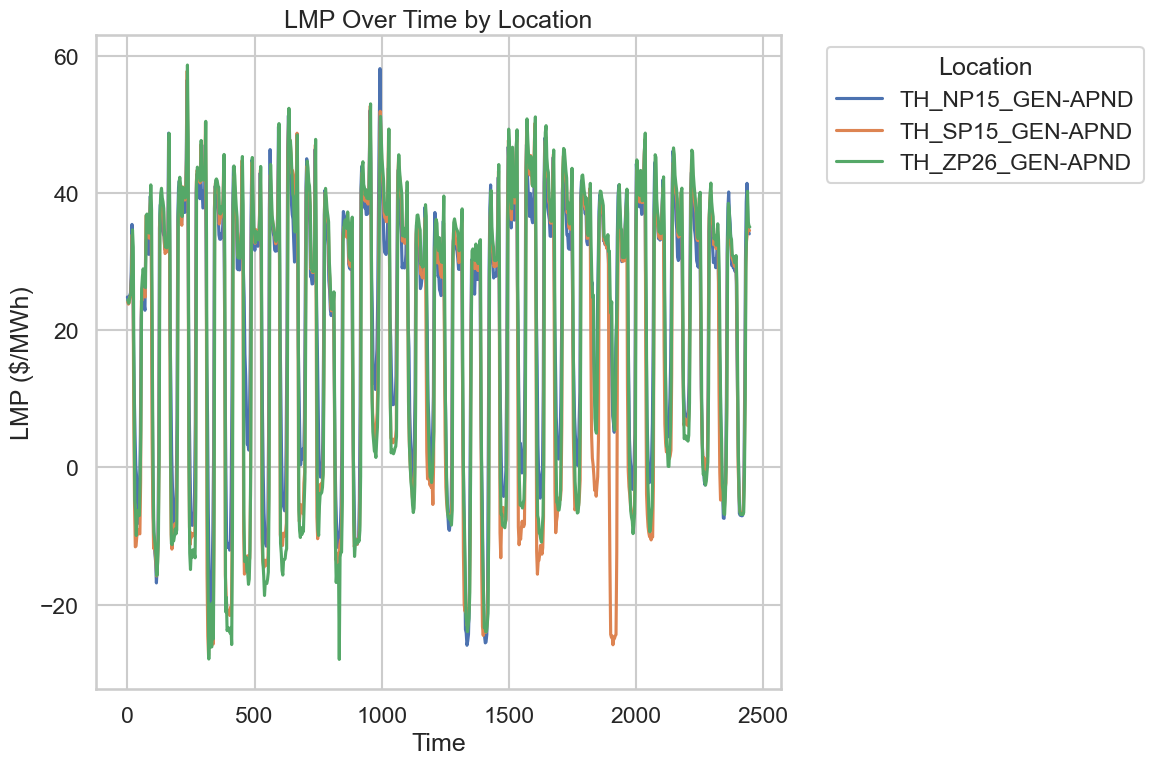

In [138]:
# Group by Location and plot each group's LMP over time
plt.figure(figsize=(12, 8))
for location, group in merged_df.groupby('Location'):
    plt.plot(group.index, group['LMP'], label=location)

plt.title('LMP Over Time by Location')
plt.xlabel('Time')
plt.ylabel('LMP ($/MWh)')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

In [139]:
negative_lmps = merged_df[merged_df['LMP'] < 0]
negative_lmps.set_index('Time', inplace=True)
negative_lmps['hour'] = negative_lmps.index.hour
negative_lmps['month'] = negative_lmps.index.month

# # Count by hour
# negative_lmps.groupby('hour').size().plot(kind='bar', title='Negative LMPs by Hour')

# Group and reset index for Plotly
hourly_counts = negative_lmps.groupby('hour').size().reset_index(name='count')

# Plot with Plotly
fig = px.bar(hourly_counts, x='hour', y='count',
             title='Negative LMPs by Hour',
             labels={'hour': 'Hour of Day', 'count': 'Number of Negative LMPs'},
             color='count',
             color_continuous_scale='Blues')

fig.show()


/var/folders/4y/y61rk3957l34yct000xkq_5r0000gn/T/ipykernel_97112/3076828422.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/4y/y61rk3957l34yct000xkq_5r0000gn/T/ipykernel_97112/3076828422.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



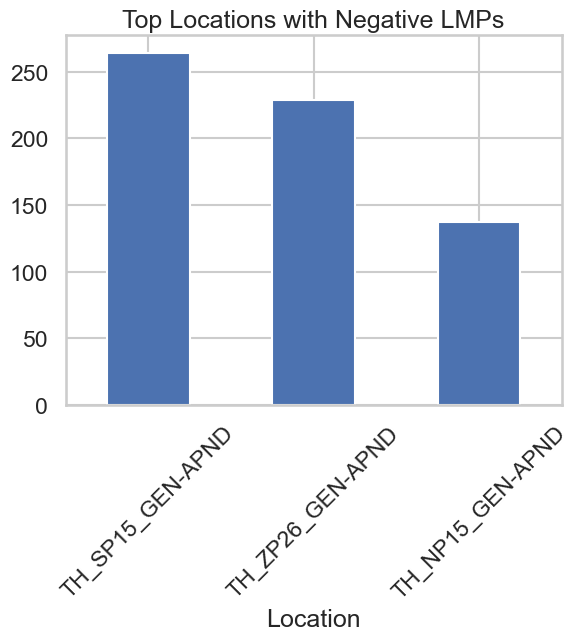

In [140]:
neg_by_location = negative_lmps['Location'].value_counts()
neg_by_location.head(10).plot(kind='bar', title='Top Locations with Negative LMPs')
plt.xticks(rotation=45)
plt.show()

In [141]:
df_NP15 = merged_df[merged_df['Location'] == 'TH_NP15_GEN-APND']
df_SP15 = merged_df[merged_df['Location'] == 'TH_SP15_GEN-APND']
df_NP15 = df_NP15.set_index('Time').sort_index()
df_SP15 = df_SP15.set_index('Time').sort_index()

df_spread = df_NP15['LMP'] - df_SP15['LMP']

# df_spread.plot(figsize=(15, 5))
# plt.title('LMP Spread between NP15 and SP15')
# plt.xlabel('Date')
# plt.ylabel('LMP Spread (NP15 - SP15)')
# plt.show()

df_spread.name = 'LMP Spread'
df_spread = df_spread.reset_index()

fig = px.line(df_spread, x='Time', y='LMP Spread',
              title='LMP Spread between NP15 and SP15',
              labels={'Time': 'Date', 'LMP Spread': 'LMP Spread (NP15 - SP15)'})

fig.show()

## NP15 Analysis

In [142]:
df_NP15 = merged_df[merged_df['Location'] == 'TH_NP15_GEN-APND']
df_NP15.head()

,Time,Market,Location,Location Type,LMP,Energy,Congestion,Loss,Solar,Wind,...,Biogas,Small Hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Other,Load
0,2025-04-01 00:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,24.87411,25.44473,-0.00829,-0.56233,694,51371,...,1724,2681,8,27320,38073,37562,8367,90486,0,257936.0
3,2025-04-01 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,24.21639,24.89866,-0.02743,-0.65483,-683,50680,...,1728,2685,4,27325,35432,33775,4562,91417,0,247558.0
6,2025-04-01 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,24.49350,25.33164,-0.03766,-0.80048,-680,49351,...,1726,2691,4,27317,35972,30646,689,90756,0,239641.0
9,2025-04-01 03:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,25.07271,25.87216,-0.02845,-0.77099,-689,48852,...,1730,2697,9,27308,33970,30283,41,90306,0,235397.0
12,2025-04-01 04:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,25.46161,26.09896,-0.02663,-0.61072,-696,48572,...,1730,2833,-17,27304,36125,31916,3151,86059,0,239154.0


In [143]:
df_NP15.columns

Index(['Time', 'Market', 'Location', 'Location Type', 'LMP', 'Energy',
       'Congestion', 'Loss', 'Solar', 'Wind', 'Geothermal', 'Biomass',
       'Biogas', 'Small Hydro', 'Coal', 'Nuclear', 'Natural Gas',
       'Large Hydro', 'Batteries', 'Imports', 'Other', 'Load'],
      dtype='object')

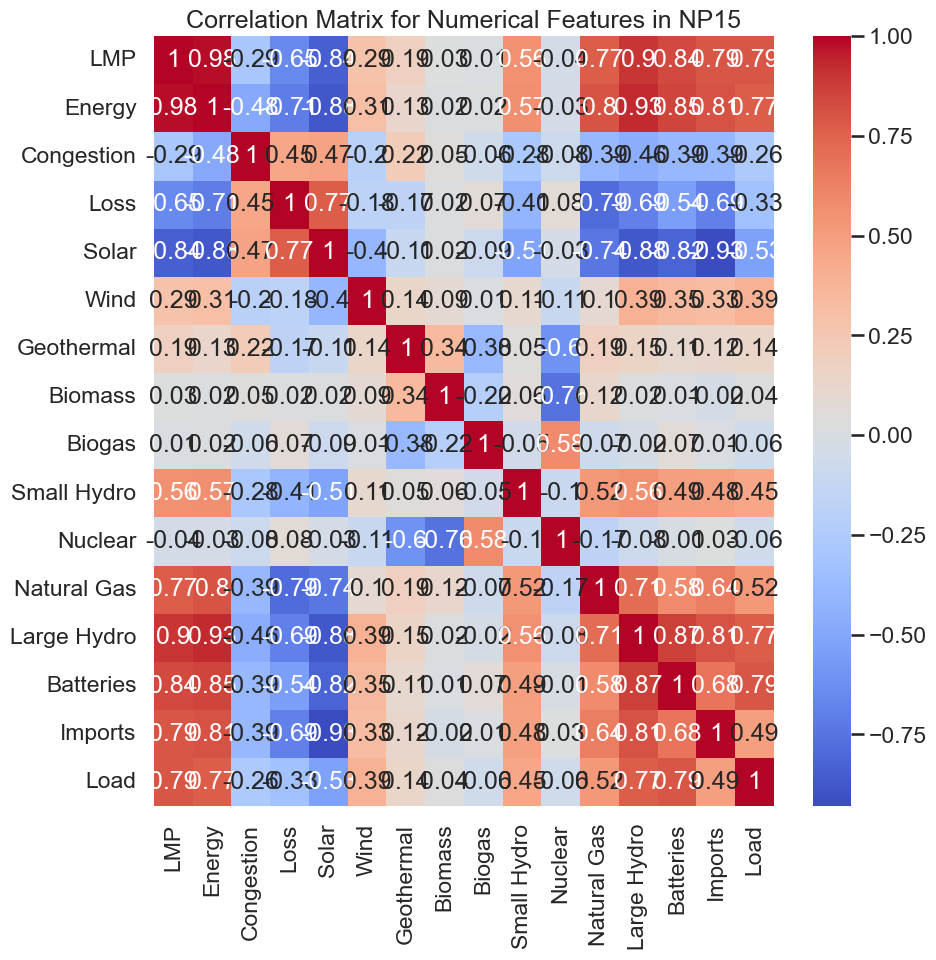

In [ ]:
num_df_NP15 = df_NP15.select_dtypes(include=['number']).drop(columns=['Coal', 'Other'])

plt.figure(figsize=(12,12))
sns.heatmap(num_df_NP15.corr().round(2), cmap = 'coolwarm', annot=True)
plt.title('Correlation Matrix for Numerical Features in NP15')
plt.show()


/var/folders/4y/y61rk3957l34yct000xkq_5r0000gn/T/ipykernel_97112/2984542982.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/4y/y61rk3957l34yct000xkq_5r0000gn/T/ipykernel_97112/2984542982.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: >

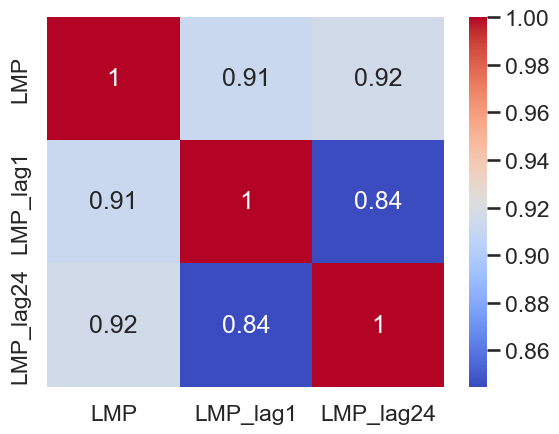

In [145]:
df_NP15['LMP_lag1'] = df_NP15['LMP'].shift(1)
df_NP15['LMP_lag24'] = df_NP15['LMP'].shift(24)
sns.heatmap(df_NP15[['LMP', 'LMP_lag1', 'LMP_lag24']].corr(), annot=True, cmap='coolwarm')

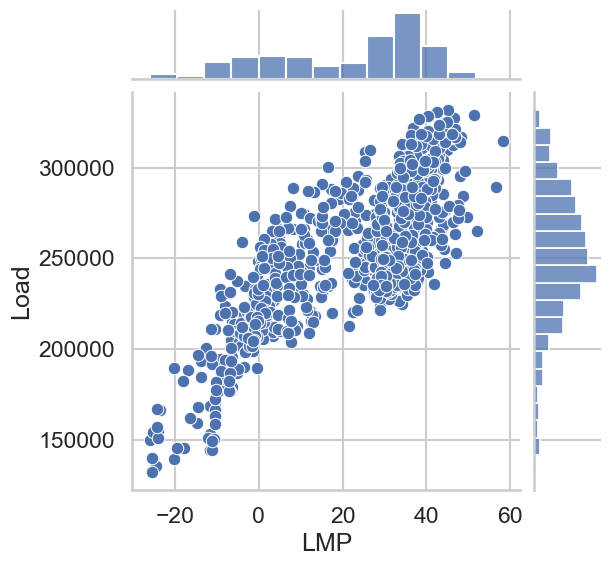

In [146]:
sns.jointplot(x='LMP', y='Load', data=df_NP15, kind='scatter')  # kde, hex, reg

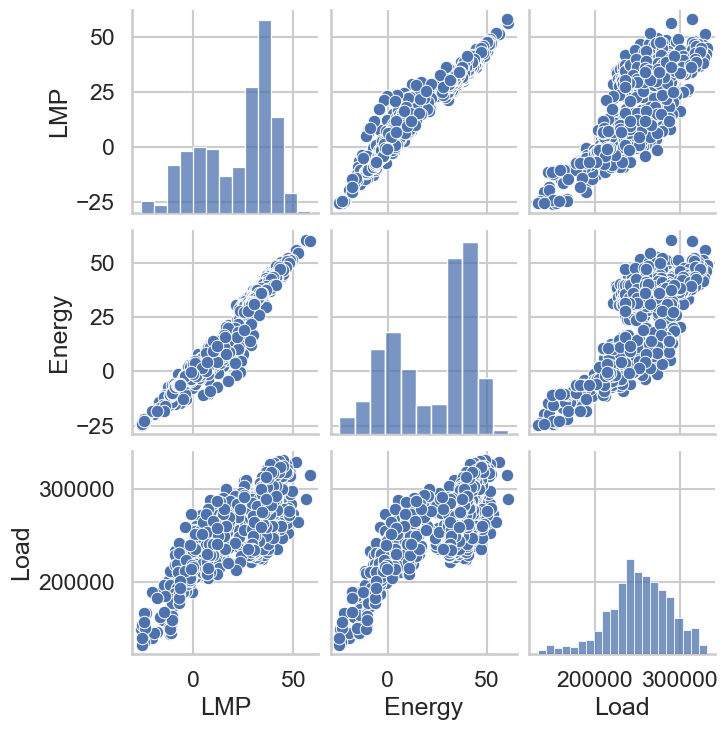

In [147]:
sns.pairplot(df_NP15[['LMP', 'Energy', 'Load']])


### Seasonal decomposition

In [148]:
### seasonal decomposition
result = seasonal_decompose(df_NP15['LMP'], model='additive', period=24)

# Build a DataFrame for plotting
df_decomposed = pd.DataFrame({
    'Time': result.observed.index,
    'Observed': result.observed,
    'Trend': result.trend,
    'Seasonal': result.seasonal,
    'Residual': result.resid
})

df_melted = df_decomposed.melt(id_vars='Time', 
                                value_vars=['Observed', 'Trend', 'Seasonal', 'Residual'],
                                var_name='Component',
                                value_name='Value')

fig = px.line(df_melted, x='Time', y='Value', color='Component',
              facet_row='Component',
              title='Seasonal Decomposition of LMP (NP15)',
              labels={'Value': 'LMP ($/MWh)', 'Time': 'Date'})

fig.update_layout(height=800, showlegend=False)
fig.show()

### ACF and PACF

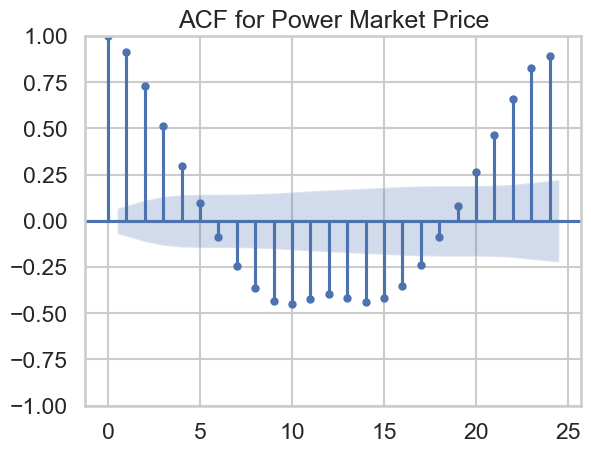

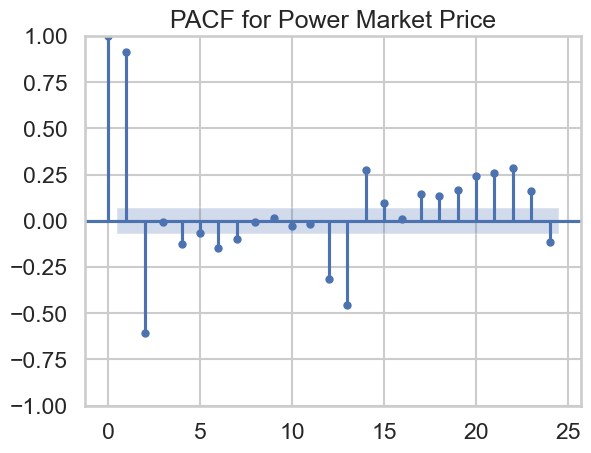

In [149]:
### acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_NP15["LMP"],lags=24,title="ACF for Power Market Price")
plt.show()

plot_pacf(df_NP15["LMP"],lags=24,title="PACF for Power Market Price")
plt.show()

### Rolling 

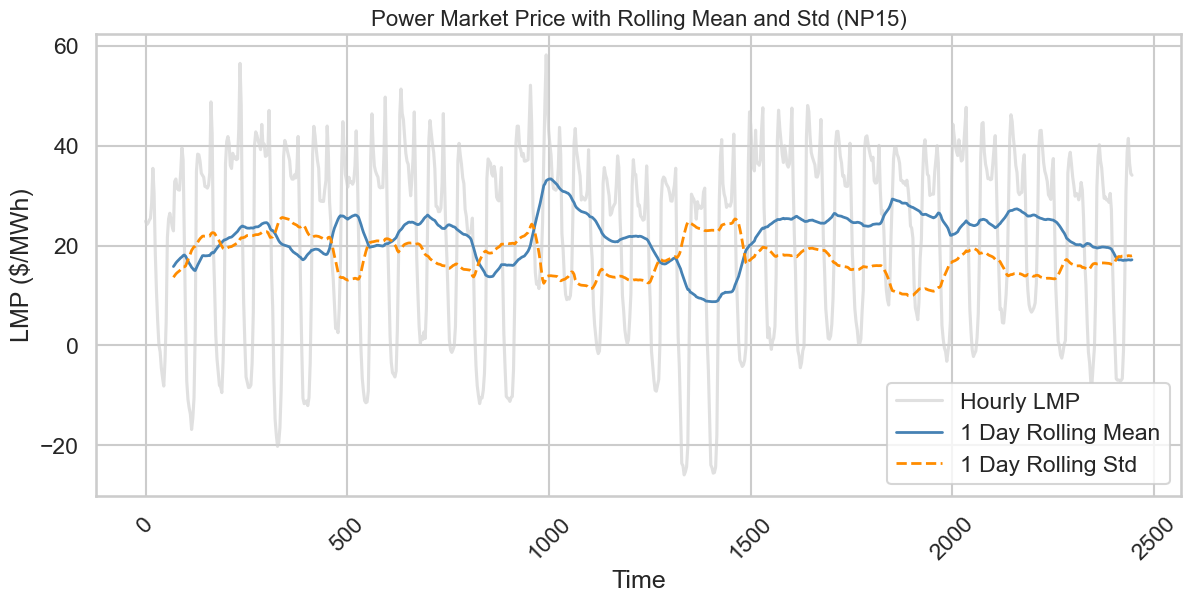

In [150]:
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(14, 6))

# Original LMP line 
plt.plot(df_NP15.index, df_NP15['LMP'], label='Hourly LMP', color='lightgray', alpha=0.7)

# Rolling mean
rolling_mean = df_NP15['LMP'].rolling(window=24).mean()
plt.plot(df_NP15.index, rolling_mean, label='1 Day Rolling Mean', color='steelblue', linewidth=2)

# Rolling std
rolling_std = df_NP15['LMP'].rolling(window=24).std()
plt.plot(df_NP15.index, rolling_std, label='1 Day Rolling Std', color='darkorange', linewidth=2, linestyle='--')

# Aesthetics
plt.title('Power Market Price with Rolling Mean and Std (NP15)', fontsize=16)
plt.xlabel('Time')
plt.ylabel('LMP ($/MWh)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


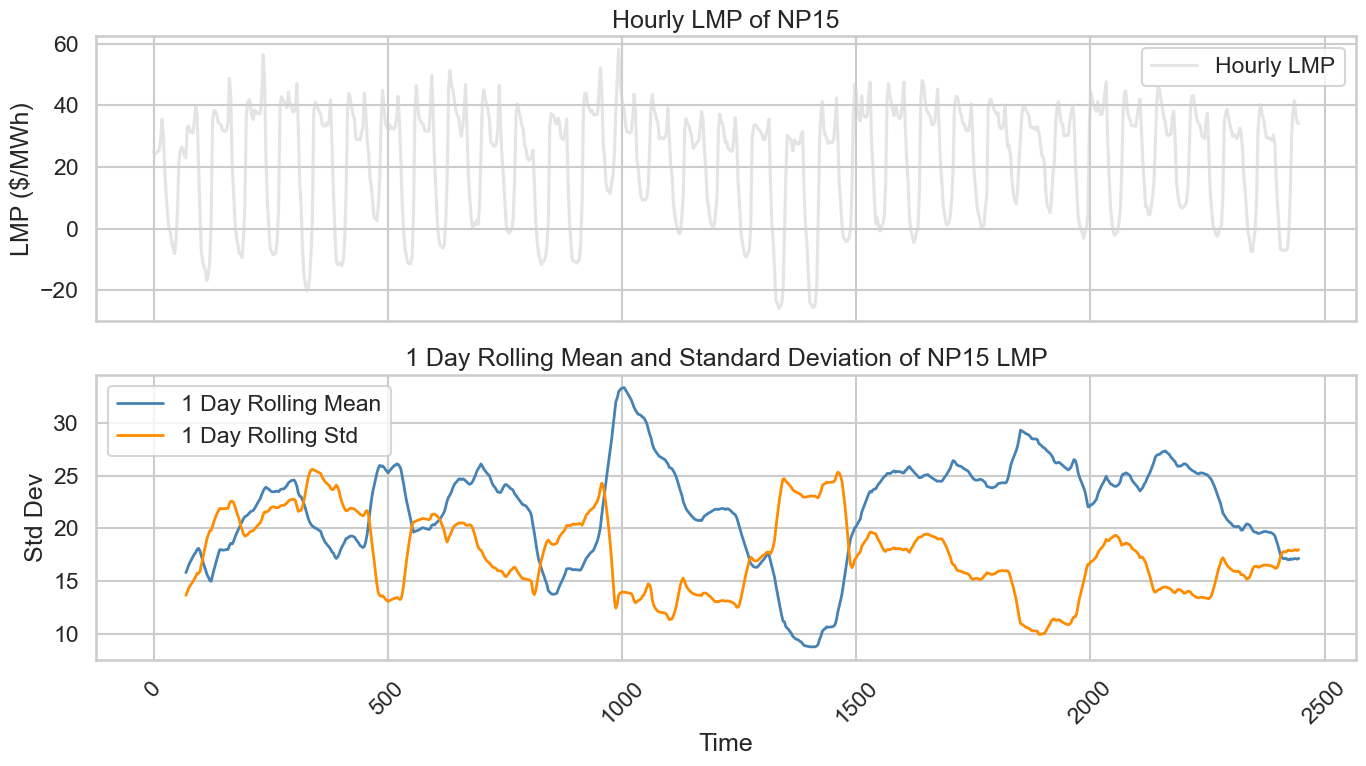

In [151]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

# Top: Rolling Mean
axes[0].plot(df_NP15.index, df_NP15['LMP'], label='Hourly LMP', color='lightgray', alpha=0.6)
axes[0].set_title('Hourly LMP of NP15')
axes[0].set_ylabel('LMP ($/MWh)')
axes[0].legend()
axes[0].grid(True)

# Bottom: Rolling Std
axes[1].plot(df_NP15.index, rolling_mean, label='1 Day Rolling Mean', color='steelblue', linewidth=2)
axes[1].plot(df_NP15.index, rolling_std, label='1 Day Rolling Std', color='darkorange', linewidth=2)
axes[1].set_title('1 Day Rolling Mean and Standard Deviation of NP15 LMP')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Std Dev')
axes[1].legend()
axes[1].grid(True)

# Final layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Time Series

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from pmdarima import auto_arima

# a random walk
adf = adfuller(df_NP15["LMP"])
print("p-value of LMP: {}".format(float(adf[1])))

p-value of LMP: 0.23356497210561938


In [153]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def make_stationary(series, max_diff=5, significance=0.05, verbose=True):
    """
    Applies differencing to a time series until it becomes stationary based on ADF test.
    
    Parameters:
    - series (pd.Series): the original time series
    - max_diff (int): maximum number of differences allowed
    - significance (float): ADF test significance level
    - verbose (bool): print details
    
    Returns:
    - diff_series (pd.Series): differenced stationary series
    - d (int): number of differences applied
    - adf_pvalue (float): p-value of final ADF test
    """
    d = 0
    current_series = series.dropna()

    while d < max_diff:
        adf_result = adfuller(current_series)
        p_value = adf_result[1]
        if verbose:
            print(f"ADF p-value at d={d}: {p_value:.5f}")

        if p_value < significance:
            break  # Stationary
        current_series = current_series.diff().dropna()
        d += 1

    if d == max_diff and p_value >= significance:
        print(f"Reached max differencing (d={max_diff}) but series may still be non-stationary.")

    return current_series, d, p_value

stationary_series, d_order, final_p = make_stationary(df_NP15["LMP"])
print(f"\n Series became stationary at d={d_order}, p={final_p:.5f}")



ADF p-value at d=0: 0.23356
ADF p-value at d=1: 0.00000

 Series became stationary at d=1, p=0.00000


### ARIMA

In [ ]:
model = auto_arima(
    df_NP15["LMP"],
    d=1, 
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True 
)

print("Optimal order:", model.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5626.748, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5352.065, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5366.631, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5624.750, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5335.983, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5337.381, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5337.429, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5333.984, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5350.065, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=5335.381, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5335.429, T

### GARCH

In [ ]:
best_aic = float('inf')
best_model = None
best_order = None

for p in range(1, 4):        
    for q in range(1, 4):
        try:
            model = arch_model(df_NP15['LMP'], vol='GARCH', p=p, q=q, dist='normal')
            res = model.fit(disp='off')
            if res.aic < best_aic:
                best_aic = res.aic
                best_model = res
                best_order = (p, q)
        except:
            continue

print(f'Best GARCH Order: {best_order}, AIC: {best_aic}')

Best GARCH Order: (1, 1), AIC: 6459.811383331082


### VAR

In [ ]:
from statsmodels.tsa.api import VAR

df_var = df_NP15[['LMP', 'Energy', 'Congestion', 'Loss']].dropna()

model = VAR(df_var) 

# Find optimal lag with AIC/BIC
lag_selection = model.select_order(30)
print(lag_selection.summary())

optimal_lag = lag_selection.aic  
results = model.fit(optimal_lag)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -16.89      -16.86   4.635e-08      -16.88
1       -20.57      -20.45   1.167e-09      -20.52
2       -21.21     -21.00*   6.146e-10      -21.13
3       -21.24      -20.94   5.948e-10      -21.13
4       -21.25      -20.85   5.901e-10      -21.10
5       -21.28      -20.79   5.706e-10      -21.10
6       -21.32      -20.74   5.495e-10      -21.10
7       -21.35      -20.67   5.369e-10      -21.08
8       -21.40      -20.62   5.099e-10      -21.10
9       -21.51      -20.64   4.552e-10      -21.18
10      -21.57      -20.61   4.308e-10      -21.20
11      -21.60      -20.54   4.184e-10      -21.19
12      -21.71      -20.57   3.723e-10      -21.27
13      -21.85      -20.61   3.238e-10      -21.38
14      -22.10      -20.77   2.516e-10      -21.59
15     -22.23*      -20.80  2.216e-10*     -21.68*
-------------------------------

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.



### SARIMAX

In [157]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")

stepwise_fit = auto_arima(
    df_NP15['LMP'],
    seasonal=True,
    m=24,  # daily data
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_fit.summary())

Performing stepwise search to minimize aic


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning:

invalid value encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning:

invalid value encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/num

 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=7049.833, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=7776.136, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=5598.129, Time=0.80 sec
 ARIMA(0,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=5.69 sec
 ARIMA(0,0,0)(1,0,2)[24] intercept   : AIC=inf, Time=6.37 sec
 ARIMA(0,0,0)(0,0,2)[24] intercept   : AIC=6009.168, Time=2.12 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=4.03 sec
 ARIMA(0,0,0)(2,0,2)[24] intercept   : AIC=inf, Time=7.46 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=4886.351, Time=1.50 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=49

### LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore

In [159]:
df = df_NP15.copy()
df = df.sort_values("Time")
lmp = df["LMP"].values.reshape(-1, 1)

# Normalize the LMP values
scaler = MinMaxScaler()
lmp_scaled = scaler.fit_transform(lmp)

# Create sequences (e.g. past 24 hours)
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_len = 24
X, y = create_sequences(lmp_scaled, seq_len)

# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [160]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)


# plt.figure(figsize=(12, 5))
# plt.plot(y_test_inv, label="Actual")
# plt.plot(y_pred_inv, label="Predicted")
# plt.title("LSTM Forecast of LMP")
# plt.legend()
# plt.show()

# Prepare DataFrame for Plotly
test_index = df.index[seq_len + split:]  
train_index = df.index[seq_len:seq_len + split] 

# Build combined DataFrame
df_plot = pd.DataFrame({
    'Time': np.concatenate([train_index, test_index]),
    'LMP': np.concatenate([scaler.inverse_transform(y_train).flatten(),
                           y_test_inv.flatten()]),
    'Type': ['Train'] * len(train_index) + ['Test Actual'] * len(test_index)
})

df_pred = pd.DataFrame({
    'Time': test_index,
    'LMP': y_pred_inv.flatten(),
    'Type': ['Test Predicted'] * len(test_index)
})

df_combined = pd.concat([df_plot, df_pred], ignore_index=True)

# Plot with Plotly Express
fig = px.line(df_combined, x='Time', y='LMP', color='Type',
              title='LSTM Forecast: Actual vs Predicted LMP',
              labels={'LMP': 'LMP ($/MWh)', 'Time': 'Date'})
fig.update_layout(height=400, width=1000)
fig.show()

Epoch 1/20


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5226 - val_loss: 0.3105
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1832 - val_loss: 0.0307
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0577 - val_loss: 0.0231
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0392 - val_loss: 0.0128
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316 - val_loss: 0.0068
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191 - val_loss: 0.0039
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - val_loss: 0.0151
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - val_loss: 0.0049
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0043
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 - val_loss: 0.0035
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.0033
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0036


## Regression

In [161]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

In [162]:
# split the train and test set and preprocess, apply the regressors
X_train, X_test, y_train, y_test = train_test_split(
    df_NP15.drop(['Time', 'Market', 'Location', 'LMP', 'Coal', 'Other'], axis=1), 
    df_NP15['LMP'], 
    test_size=0.2, 
    random_state=42)  

num_pipeline = Pipeline([
    ('impute',SimpleImputer(strategy='median')), # median
    ('scale',StandardScaler()),
    ('pca', PCA(n_components=3))
    ])

# cat_pipeline = Pipeline([
#     ('impute', SimpleImputer(strategy='most_frequent')), # most frequent
#     ('encode', OneHotEncoder(drop='first', handle_unknown='ignore'))  
# ])

preprocessing_pipeline = ColumnTransformer([
    ('num', num_pipeline, ['Solar', 'Wind', 'Geothermal', 'Biomass',
       'Biogas', 'Small Hydro', 'Nuclear', 'Natural Gas',
       'Large Hydro', 'Batteries', 'Imports', 'Load'])
    # ('cat', cat_pipeline, ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side'])
    ])

X_train_prepared = preprocessing_pipeline.fit_transform(X_train)
X_test_prepared = preprocessing_pipeline.transform(X_test)

regressors = {                         
    "MLP regressor": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42), 
    "KNN regressor": KNeighborsRegressor(n_neighbors=5),                                         
    "SVR(linear)": SVR(kernel='linear', C=0.025),                                                                                
    "Decision Tree": DecisionTreeRegressor(random_state=42),                                           
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),         
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42), 
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.05,random_state=42),                                                                                            
}

# Train and evaluate each regressor
for name, clf in regressors.items():
    clf.fit(X_train_prepared, y_train)
    y_pred = clf.predict(X_test_prepared)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n{name}")
    print(f"  R² Score : {r2:.4f}")
    print(f"  MAE      : {mae:.2f}")

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

invalid value encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12


MLP regressor
  R² Score : 0.8970
  MAE      : 4.87

KNN regressor
  R² Score : 0.8945
  MAE      : 4.70

SVR(linear)
  R² Score : 0.8464
  MAE      : 5.87

Decision Tree
  R² Score : 0.8066
  MAE      : 6.38

Random Forest
  R² Score : 0.8846
  MAE      : 5.12

AdaBoost
  R² Score : 0.8710
  MAE      : 5.60

LightGBM
  R² Score : 0.8856
  MAE      : 5.03


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



In [163]:
# tune classifier parameters

def tune_regressors(X, y):
    param_grids = {
        "MLP Regressor": {
            'hidden_layer_sizes': [(50,), (100,)],
            'learning_rate_init': [0.001, 0.01],
            'max_iter': [500, 1000], 
        },
        "KNN Regressor": {
            'n_neighbors': [3, 5, 7, 9, 15],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        },
        "LightGBM": {
            'n_estimators': [100, 300],
            'learning_rate': [0.05, 0.1],
            'num_leaves': [15, 31, 63],
            'verbosity': [-1]
        }
    }

    regressors = {
        "MLP Regressor": MLPRegressor(random_state=42),
        "KNN Regressor": KNeighborsRegressor(),
        "LightGBM": LGBMRegressor(random_state=42)
    }

    best_models = {}

    for name, clf in regressors.items():
        print(f"\n Tuning {name}")
        grid = GridSearchCV(clf, param_grids[name], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
        grid.fit(X, y)
        print(f"Best parameters: {grid.best_params_}")
        print(f"Best CV RMSE: {-grid.best_score_:.4f}")
        best_models[name] = grid.best_estimator_

    return best_models

best_models = tune_regressors(X_train_prepared, y_train)


 Tuning MLP Regressor


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encount

Best parameters: {'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 1000}
Best CV RMSE: 5.7557

 Tuning KNN Regressor
Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best CV RMSE: 5.5110

 Tuning LightGBM


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.w

Best parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 15, 'verbosity': -1}
Best CV RMSE: 5.7807


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [164]:
# tuned model
ensemble_estimators = [
    ("MLP Regressor", MLPRegressor(hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=500, random_state=42)),  # regression equivalent of LogisticRegression
    ("KNN Regressor", KNeighborsRegressor(n_neighbors=9, weights='distance', metric='euclidean')),
    ("LightGBM", LGBMRegressor(learning_rate = 0.05, n_estimators =100, num_leaves = 31, verbosity = -1, random_state=42)),
]

ensemble_reg = VotingRegressor(
    estimators=ensemble_estimators
)

# Fit and score
ensemble_reg.fit(X_train_prepared, y_train)
ensemble_r2 = ensemble_reg.score(X_test_prepared, y_test)
print(f"Ensemble VotingRegressor R² Score: {ensemble_r2:.4f}")

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



Ensemble VotingRegressor R² Score: 0.8964


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

